In [ ]:
!pip install segmentation_models_pytorch
!wget https://raw.githubusercontent.com/johschmidt42/PyTorch-2D-3D-UNet-Tutorial/master/trainer.py

In [3]:
! git clone https://github.com/HSE-LAMBDA/RheologyReconstruction.git

Cloning into 'RheologyReconstruction'...
remote: Enumerating objects: 461, done.
remote: Counting objects: 100% (461/461), done.
remote: Compressing objects: 100% (312/312), done.
remote: Total 461 (delta 218), reused 323 (delta 135), pack-reused 0
Receiving objects: 100% (461/461), 19.30 MiB | 17.71 MiB/s, done.
Resolving deltas: 100% (218/218), done.


In [ ]:
! pip install dvc
! pip install 'dvc[azure]'

In [ ]:
!cd RheologyReconstruction/datasets/ && dvc pull heterogeneity.tar.xz.dvc

In [ ]:
!cd RheologyReconstruction/datasets/ && tar -xvf heterogeneity.tar.xz

In [39]:
!rm *.py
!ls

datasets.py.1	  no_skip_unet.py.1  RheologyReconstruction
my_trainers.py.1  __pycache__	     sample_data


In [ ]:
!wget https://raw.githubusercontent.com/NechepurencoIvan/ML_project/main/datasets.py
!wget https://raw.githubusercontent.com/NechepurencoIvan/ML_project/main/my_trainers.py
!wget https://raw.githubusercontent.com/NechepurencoIvan/ML_project/main/no_skip_unet.py
!wget https://raw.githubusercontent.com/johschmidt42/PyTorch-2D-3D-UNet-Tutorial/master/trainer.py

In [ ]:
!cat datasets.py

In [42]:
from datasets import *
from my_trainers import *
from no_skip_unet import *
from trainer import Trainer

In [43]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

In [44]:
from numpy.fft import fft2, fftshift, ifftshift

def transform_seismogram(seismogram):
  seismogram_transformed = []
  for i in range(2):
      transformed = fftshift(fft2(ifftshift(seismogram[i])))
      seismogram_transformed.append(transformed.real)
      seismogram_transformed.append(transformed.imag)
  return np.array(seismogram_transformed)
#seismograms_transformed = np.array([transform_seismogram(seismogram) for seismogram in seismograms])
#seismograms_transformed.shape

In [45]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import torch
from torch import nn

In [46]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def __repr__(self):
        return f'View{self.shape}'

    def forward(self, input):
        '''
        Reshapes the input according to the shape saved in the view data structure.
        '''
        batch_size = input.size(0)
        shape = (batch_size, *self.shape)
        out = input.view(shape) # [:, 1] # torch.gather(, 1, torch.tensor([0]))
        return out

In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [48]:
import os
from numpy.fft import fft2, fftshift, ifftshift
from torch.utils.data import Dataset
import re

In [49]:
#from trainer import Trainer

In [50]:
ae_bath_size = 20
a_training_dataset = AutoencodeDataset('RheologyReconstruction/datasets/heterogeneity/',(0, 900))
a_training_dataloader = torch.utils.data.DataLoader(
    dataset=a_training_dataset, batch_size=ae_bath_size, shuffle=True)
a_val_dataset = AutoencodeDataset('RheologyReconstruction/datasets/heterogeneity/',(900, 1000))
a_val_dataloader = torch.utils.data.DataLoader(
    dataset=a_val_dataset, batch_size=ae_bath_size, shuffle=True)

In [51]:
ae_model = nn.Sequential(
    smp.Unet(
        encoder_name="resnet18",  
        in_channels=4,      
        classes=4,
    ),
    torch.nn.Flatten()
)

if torch.cuda.is_available():
    ae_model.cuda()

In [52]:
loss = [torch.nn.MSELoss(), torch.nn.L1Loss()][1]
ae_criterion = loss #
ae_optimizer = torch.optim.Adam(ae_model.parameters(), lr=1e-4)
ae_loss_fn = loss # torch.nn.L1Loss()

In [53]:
ae_trainer = Trainer(model=ae_model,
                  device=device,
                  criterion=ae_criterion,
                  optimizer=ae_optimizer,
                  training_DataLoader=a_training_dataloader,
                  validation_DataLoader=a_val_dataloader,
                  lr_scheduler=None,
                  epochs=100,
                  epoch=0,
                  notebook=True)

In [ ]:
ae_history = ae_trainer.run_trainer()

In [57]:
#import torch

Теперь пробуем тренировать на основном задании

In [58]:
bath_size = 10
do_transform = False
training_dataset = SeismogramDataset('RheologyReconstruction/datasets/heterogeneity/',(0, 4000), do_transform=do_transform)
training_dataloader = torch.utils.data.DataLoader(
    dataset=training_dataset, batch_size=bath_size, shuffle=True)
val_dataset = SeismogramDataset('RheologyReconstruction/datasets/heterogeneity/',(4000, 4500), do_transform=do_transform)
val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=bath_size, shuffle=True)
test_dataset = SeismogramDataset('RheologyReconstruction/datasets/heterogeneity/',(4500, 5000), do_transform=do_transform)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=500, shuffle=False)

In [ ]:
in_channels = next(iter(training_dataloader))[0].shape[1]
encoder_depth = 5
in_channels

In [ ]:
model = MyUnet(
      encoder_name="resnet34",  
      encoder_depth = 5,
      in_channels=in_channels,      
      classes=2,
  )

In [61]:
"""
model = nn.Sequential(
    smp.Unet(
        encoder_name="resnet18",  
        in_channels=in_channels,      
        classes=2,
    ),
)
"""
None

In [ ]:
if torch.cuda.is_available():
    model.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()
trainer = MyTrainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=training_dataloader,
                  validation_DataLoader=val_dataloader,
                  lr_scheduler=None,
                  epochs=120,
                  epoch=0,
                  notebook=True)
history = trainer.run_trainer()

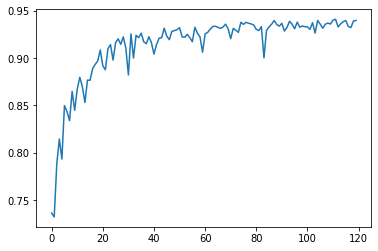

In [334]:
plt.plot(history['val_IOU'])

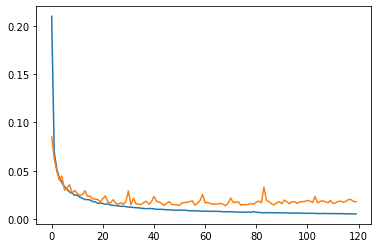

In [335]:
plt.title("")
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])

In [336]:
history['val_loss'][-1]

0.017829289510846138

In [337]:
history['val_IOU'][-1]

0.9394974207878113

In [276]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [290]:
!mkdir /content/drive/MyDrive/saved_train_results

In [338]:
torch.save(model, "/content/drive/MyDrive/saved_ml_models/UNet_no_skip_without_fourrier")

In [340]:
with open("/content/drive/MyDrive/saved_train_results/UNet_no_skip_without_fourrier.pckl", "wb") as f:
  pickle.dump(history, f)

In [342]:
with open("/content/drive/MyDrive/saved_train_results/UNet_without_fourrier.pckl", "rb") as f:
  history2 = pickle.load(f)

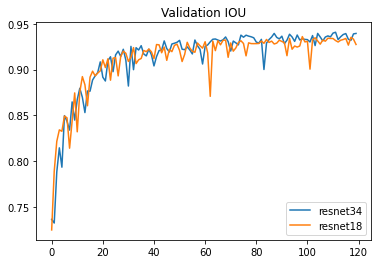

In [346]:
plt.title('Validation IOU')
plt.plot(history['val_IOU'], label='resnet34')
plt.plot(history2['val_IOU'], label='resnet18')
plt.legend()

Рисуем результаты

In [ ]:
batch = next(iter(test_dataloader))

proba = torch.nn.Softmax()(model(batch[0].cuda())).cpu().detach().numpy()[:,1]
proba.shape

In [263]:
ground = batch[1].cpu().numpy()

In [264]:
pred = proba >= 0.5
print(f"Test accuracy: {np.mean(pred == ground )}")

Test accuracy: 0.9908951416015624


In [275]:
CE = torch.nn.CrossEntropyLoss()(model(batch[0][:200].cuda()), batch[1][:200].cuda())
print(f"Tesr CE: {CE.item()}")

Tesr CE: 0.02803993411362171


In [265]:
IOU = np.sum(pred * ground) / np.sum((pred + ground) > 0)
print(f"Test IOU: {IOU}")

Test IOU: 0.8874734286908283


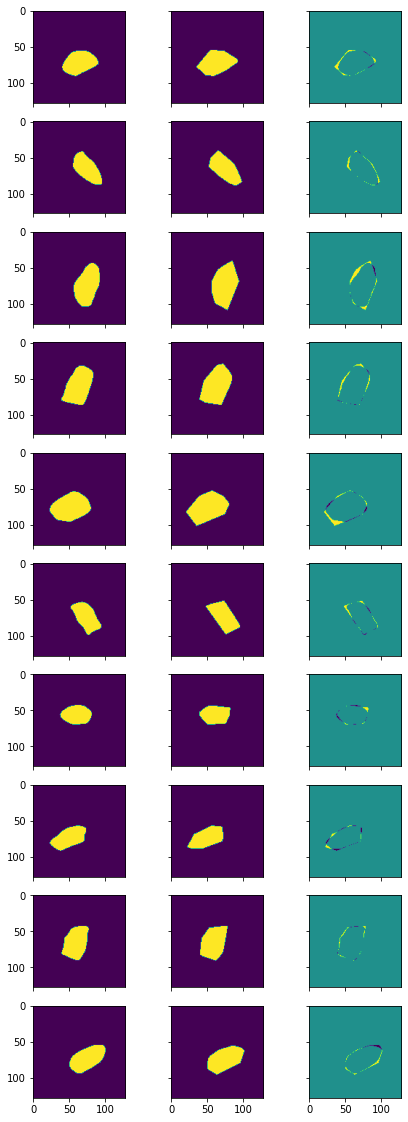

In [277]:
fig, ax = plt.subplots(10, 3, sharey=True, sharex=True, figsize=(7, 20))
fig.patch.set_visible(False)

for i, (pr, gt) in enumerate(zip(pred[:10], ground)):
  ax[i][0].imshow(pr) #.shape
  ax[i][1].imshow(gt)
  ax[i][2].imshow(gt - pr)